# Load modules and dataset

In [11]:
import sys
import os
import numpy as np
import pandas as pd
import datetime

In [12]:
train_path = '../../../data/mind_news/'
train_news = pd.read_csv(train_path + 'demo_news.tsv', header=None ,sep='\t')
train_behaviors = pd.read_csv(train_path + 'demo_behaviors.tsv', header=None, sep='\t')

# valid_path = '../../../data/mind_news/mind_small_dev/'
# valid_news = pd.read_csv(valid_path + 'news.tsv', header=None, sep='\t')
# valid_behaviors = pd.read_csv(valid_path + 'behaviors.tsv', header=None, sep='\t')

In [14]:
news_cols = ['news_id','category','subcategory','title','abstract','url',
             'title_entities','abstract_entities']
behavior_cols = ['impression_id','user_id','time','click_history','impression']

train_news.columns = news_cols
train_behaviors.columns = behavior_cols

# EDA

In [16]:
train_behaviors.head(3)
# impression_id, click_history -> remove
# time -> Reshape Unix epoch format
# impression -> 1이면 클릭, 0이면 non-click, news_id_1|news_id_2| 이런 형태로 바꿔야 함

impression_id user_id                    time  \
0              1  U82271   11/11/2019 3:28:58 PM   
1              2  U84185  11/12/2019 10:36:47 AM   
2              3  U11552   11/11/2019 1:03:52 PM   

                                       click_history  \
0             N3130 N11621 N12917 N4574 N12140 N9748   
1  N27209 N11723 N4617 N12320 N11333 N24461 N2211...   
2                                              N2139   

                                          impression  
0  N13390-0 N7180-0 N20785-0 N6937-0 N15776-0 N25...  
1  N13089-0 N18101-0 N1248-0 N26273-0 N12770-1 N1...  
2                         N18390-0 N10537-0 N23967-1

In [17]:
train_behaviors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22034 entries, 0 to 22033
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   impression_id  22034 non-null  int64 
 1   user_id        22034 non-null  object
 2   time           22034 non-null  object
 3   click_history  21480 non-null  object
 4   impression     22034 non-null  object
dtypes: int64(1), object(4)
memory usage: 860.8+ KB


In [25]:
len(train_behaviors['user_id'].unique())

5000

In [18]:
train_news.head(3)
# news_id, category, subcategory, title 남기기

news_id   category      subcategory  \
0   N3112  lifestyle  lifestyleroyals   
1  N10399       news        newsworld   
2  N12103     health           voices   

                                               title  \
0  The Brands Queen Elizabeth, Prince Charles, an...   
1  The Cost of Trump's Aid Freeze in the Trenches...   
2  I Was An NBA Wife. Here's How It Affected My M...   

                                            abstract  \
0  Shop the notebooks, jackets, and more that the...   
1  Lt. Ivan Molchanets peeked over a parapet of s...   
2  I felt like I was a fraud, and being an NBA wi...   

                                                 url  \
0  https://www.msn.com/en-us/lifestyle/lifestyler...   
1  https://www.msn.com/en-us/news/world/the-cost-...   
2  https://www.msn.com/en-us/health/voices/i-was-...   

                                      title_entities  \
0  [{"Label": "Prince Philip, Duke of Edinburgh",...   
1                                                 []   
2                                                 []   

                                   abstract_entities  
0                                                 []  
1  [{"Label": "Ukraine", "Type": "G", "WikidataId...  
2  [{"Label": "National Basketball Association", ...

In [19]:
train_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26740 entries, 0 to 26739
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   news_id            26740 non-null  object
 1   category           26740 non-null  object
 2   subcategory        26740 non-null  object
 3   title              26740 non-null  object
 4   abstract           25453 non-null  object
 5   url                26740 non-null  object
 6   title_entities     26737 non-null  object
 7   abstract_entities  26737 non-null  object
dtypes: object(8)
memory usage: 1.6+ MB


In [20]:
# user 방문빈도 : 5천 유저, 2.6만 아이템, 2만 인터랙션
train_behaviors['user_id'].count()
train_behaviors['user_id'].value_counts()

U44201    40
U79449    37
U57047    36
U79210    35
U85878    34
          ..
U82995     1
U24348     1
U17582     1
U72289     1
U24984     1
Name: user_id, Length: 5000, dtype: int64

<AxesSubplot:ylabel='Frequency'>

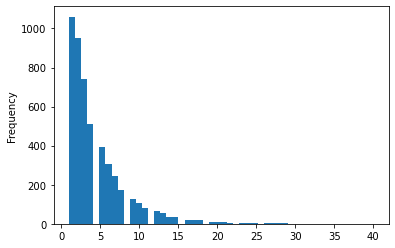

In [21]:
# user 방문빈도 histogram
train_behaviors['user_id'].value_counts().plot(kind='hist', bins=50)

In [22]:
# 모든 row에 click이 발생했는지 확인 
train_behaviors['impression'].str.contains('1').count() 

22034

# item_df 전처리

In [26]:
# 필요한 컬럼만 남김
train_news = train_news.iloc[:,:4]

In [12]:
train_news.columns

Index(['news_id', 'category', 'subcategory', 'title'], dtype='object')

In [27]:
train_items_df = train_news.rename(columns = {'news_id':'ITEM_ID',
                                              'category':'CATEGORY',
                                              'subcategory':'SUBCATEGORY',
                                              'title':'TITLE'})

In [28]:
train_items_df.head(3)

ITEM_ID   CATEGORY      SUBCATEGORY  \
0   N3112  lifestyle  lifestyleroyals   
1  N10399       news        newsworld   
2  N12103     health           voices   

                                               TITLE  
0  The Brands Queen Elizabeth, Prince Charles, an...  
1  The Cost of Trump's Aid Freeze in the Trenches...  
2  I Was An NBA Wife. Here's How It Affected My M...

In [29]:
train_items_df = train_items_df.astype('string')

In [30]:
# save as csv file
train_items_df.to_csv('../../../data/mind_news/processed/mini_items_df.csv', index=False)


# interaction_df 전처리

In [31]:
train_behaviors.columns

Index(['impression_id', 'user_id', 'time', 'click_history', 'impression'], dtype='object')

In [32]:
# 필요한 컬럼만 남김
train_behaviors = train_behaviors.drop(['impression_id','click_history'], axis=1)
train_behaviors.head(2)

user_id                    time  \
0  U82271   11/11/2019 3:28:58 PM   
1  U84185  11/12/2019 10:36:47 AM   

                                          impression  
0  N13390-0 N7180-0 N20785-0 N6937-0 N15776-0 N25...  
1  N13089-0 N18101-0 N1248-0 N26273-0 N12770-1 N1...

In [33]:
## time 포맷 변경 : string => UTC => timestamp(Unix epoch)
# train_behaviors.loc[train_behaviors['time'].str.contains('PM')].head(3)
train_behaviors['time'] = train_behaviors['time'].apply(lambda x: datetime.datetime.strptime(x, '%m/%d/%Y %I:%M:%S %p').timestamp())
train_behaviors.head()

user_id          time                                         impression
0  U82271  1.573454e+09  N13390-0 N7180-0 N20785-0 N6937-0 N15776-0 N25...
1  U84185  1.573523e+09  N13089-0 N18101-0 N1248-0 N26273-0 N12770-1 N1...
2  U11552  1.573445e+09                         N18390-0 N10537-0 N23967-1
3  U68381  1.573422e+09  N15660-0 N18609-0 N2831-0 N5677-0 N19010-0 N15...
4  U52303  1.573496e+09                                   N15645-0 N7911-1

In [34]:
# clicked item 추출 : 'item_id'
train_behaviors['item_id'] = train_behaviors['impression'].str.split('-1',expand=True)[0].str[-6:]
train_behaviors.head(3)

user_id          time                                         impression  \
0  U82271  1.573454e+09  N13390-0 N7180-0 N20785-0 N6937-0 N15776-0 N25...   
1  U84185  1.573523e+09  N13089-0 N18101-0 N1248-0 N26273-0 N12770-1 N1...   
2  U11552  1.573445e+09                         N18390-0 N10537-0 N23967-1   

  item_id  
0  N15368  
1  N12770  
2  N23967

In [35]:
train_behaviors

user_id          time  \
0      U82271  1.573454e+09   
1      U84185  1.573523e+09   
2      U11552  1.573445e+09   
3      U68381  1.573422e+09   
4      U52303  1.573496e+09   
...       ...           ...   
22029  U69508  1.573495e+09   
22030  U79085  1.573693e+09   
22031  U46989  1.573688e+09   
22032  U49050  1.573700e+09   
22033   U6774  1.573252e+09   

                                              impression item_id  
0      N13390-0 N7180-0 N20785-0 N6937-0 N15776-0 N25...  N15368  
1      N13089-0 N18101-0 N1248-0 N26273-0 N12770-1 N1...  N12770  
2                             N18390-0 N10537-0 N23967-1  N23967  
3      N15660-0 N18609-0 N2831-0 N5677-0 N19010-0 N15...  N18390  
4                                       N15645-0 N7911-1   N7911  
...                                                  ...     ...  
22029  N16297-0 N15645-0 N20630-0 N10602-0 N27294-0 N...   N9916  
22030  N27355-0 N9809-0 N20882-0 N8787-0 N25926-0 N38...  N13282  
22031  N13316-0 N23592-0 N10240-0 N1994-0 N26998-0 N1...  N13247  
22032  N23982-0 N17424-0 N17157-0 N4324-0 N22216-0 N1...  N13557  
22033  N5109-0 N7452-0 N13064-0 N26428-0 N22785-0 N23...   N4326  

[22034 rows x 4 columns]

In [36]:
# impression 포맷 변경 (| pipe 기호로 연결하기)
train_behaviors['impression'] = train_behaviors['impression'].str.replace('-1','|')
train_behaviors['impression'] = train_behaviors['impression'].str.replace('-0','|')
train_behaviors['impression'] = train_behaviors['impression'].str.replace(' ','')
train_behaviors['impression'] = train_behaviors['impression'].str[:-1]

train_behaviors.head(10)

user_id          time                                         impression  \
0  U82271  1.573454e+09  N13390|N7180|N20785|N6937|N15776|N25810|N20820...   
1  U84185  1.573523e+09     N13089|N18101|N1248|N26273|N12770|N1132|N13649   
2  U11552  1.573445e+09                               N18390|N10537|N23967   
3  U68381  1.573422e+09  N15660|N18609|N2831|N5677|N19010|N1502|N19215|...   
4  U52303  1.573496e+09                                       N15645|N7911   
5  U26536  1.573453e+09  N15244|N2167|N20122|N16945|N9480|N3600|N7180|N...   
6  U47186  1.573609e+09  N20702|N24545|N17138|N2755|N9671|N4541|N2449|N...   
7  U63195  1.573370e+09  N10550|N16945|N8256|N26463|N15037|N18038|N1257...   
8  U69242  1.573698e+09  N2818|N17978|N13646|N15605|N27918|N10729|N2558...   
9  U70695  1.573491e+09  N17632|N16474|N16008|N3244|N17968|N22163|N8562...   

  item_id  
0  N15368  
1  N12770  
2  N23967  
3  N18390  
4   N7911  
5  N14475  
6  N11567  
7  N16945  
8   N9133  
9   N5051

<AxesSubplot:ylabel='Frequency'>

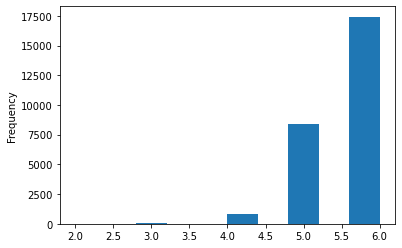

In [37]:
# news_id 문자열 길이가 3~6임 : 정리 필요
train_news['news_id'].apply(lambda x: len(x)).plot(kind='hist')

In [38]:
display(train_news[train_news['news_id'].apply(lambda x: len(x))<6].sample(3))
len(train_news[train_news['news_id'].apply(lambda x: len(x))<6])

news_id category      subcategory  \
17086   N6820   travel    travelarticle   
10617   N4006    music  music-celebrity   
3022    N5739   sports     football_nfl   

                                                   title  
17086  Retro Indy 1918: Revelry in Indianapolis on Ar...  
10617  Chrissy Teigen, John Legend Pose With Luna and...  
3022   32 things we learned from Week 8 of the 2019 N...

9317

In [39]:
train_behaviors['item_id'] = 'N'+train_behaviors['item_id'].str.split('N',expand=True)[1]
train_behaviors.head()

user_id          time                                         impression  \
0  U82271  1.573454e+09  N13390|N7180|N20785|N6937|N15776|N25810|N20820...   
1  U84185  1.573523e+09     N13089|N18101|N1248|N26273|N12770|N1132|N13649   
2  U11552  1.573445e+09                               N18390|N10537|N23967   
3  U68381  1.573422e+09  N15660|N18609|N2831|N5677|N19010|N1502|N19215|...   
4  U52303  1.573496e+09                                       N15645|N7911   

  item_id  
0  N15368  
1  N12770  
2  N23967  
3  N18390  
4   N7911

In [40]:
train_behaviors.columns

Index(['user_id', 'time', 'impression', 'item_id'], dtype='object')

In [41]:
# EVENT_TYPE 추가
train_behaviors['EVENT_TYPE'] = 'click'
train_behaviors.head(3)

user_id          time                                         impression  \
0  U82271  1.573454e+09  N13390|N7180|N20785|N6937|N15776|N25810|N20820...   
1  U84185  1.573523e+09     N13089|N18101|N1248|N26273|N12770|N1132|N13649   
2  U11552  1.573445e+09                               N18390|N10537|N23967   

  item_id EVENT_TYPE  
0  N15368      click  
1  N12770      click  
2  N23967      click

In [42]:
# Rename the column headers to a more standard naming convention for AWS Personalize import job
train_interactions_df = train_behaviors.rename(columns = {'user_id':'USER_ID',
                                                          'item_id':'ITEM_ID',
                                                          'time':'TIMESTAMP',
                                                          'impression':'IMPRESSION'})

train_interactions_df.head(3)

USER_ID     TIMESTAMP                                         IMPRESSION  \
0  U82271  1.573454e+09  N13390|N7180|N20785|N6937|N15776|N25810|N20820...   
1  U84185  1.573523e+09     N13089|N18101|N1248|N26273|N12770|N1132|N13649   
2  U11552  1.573445e+09                               N18390|N10537|N23967   

  ITEM_ID EVENT_TYPE  
0  N15368      click  
1  N12770      click  
2  N23967      click

In [43]:
# Change timestamp data type as int
train_interactions_df = train_interactions_df.astype({'USER_ID':'string',
                                                    'IMPRESSION':'string',
                                                    'ITEM_ID':'string',
                                                    'TIMESTAMP': 'int64',
                                                    'EVENT_TYPE':'string'})


train_interactions_df.dtypes

USER_ID       string
TIMESTAMP      int64
IMPRESSION    string
ITEM_ID       string
EVENT_TYPE    string
dtype: object

In [44]:
train_interactions_df.to_csv('../../../data/mind_news/processed/mini_interactions_df.csv', index=False)


# Mini MIND